# MIS 373 Project: Austin Animal Shelter Outcomes

Jennifer Lei, Austin McCartney, Andy Pham, Lucas Stephens

In [1]:
import pandas as pd
from pandas import Series, DataFrame
from patsy import dmatrices
import warnings
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from StringIO import StringIO
from sklearn.model_selection import cross_val_score, StratifiedKFold

import sys
sys.setrecursionlimit(10000)

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Dataset:

In [2]:
df = pd.read_csv('aac_shelter_outcomes.csv')
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


## Preprocessing:

Removed duplicates and unnecessary columns.

In [3]:
df.drop_duplicates(['animal_id'], keep='last', inplace=True)

df.drop(labels=['animal_id', 'monthyear'], axis=1, inplace=True)

df.head()

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


Added a feature called 'has_name' indicating if the animal was named or not.

In [4]:
mask = df['name'].isnull()
df['has_name'] = 1
df['has_name'][mask] = 0

Added a feature called 'days_alive', then used it to place each data point into one of 5 possible 'age_binned' values.

In [5]:
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y-%m-%d')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
df['days_alive'] = df['datetime'].sub(df['date_of_birth'], axis = 0)
df['days_alive'] = df['days_alive'].dt.days
df = df[df['date_of_birth'] < df['datetime']]
df['age_binned'] = pd.qcut(df['days_alive'], 5)

Extraced month for each data point.

In [6]:
def get_month(date):
    return date.month

df['month'] = df['datetime'].map(get_month)

Set whether or not an animal was adopted as the target.

In [7]:
mask = df['outcome_type'] == 'Adoption'
df['adopted'] = 0
df['adopted'][mask] = 1

In [8]:
df.head()

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,days_alive,age_binned,month,adopted
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,0,15,"(-0.001, 75.0]",7,0
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,1,366,"(248.0, 554.0]",11,0
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,429,"(248.0, 554.0]",6,1
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,1,3300,"(1139.0, 9137.0]",6,0
4,5 months,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,0,181,"(75.0, 248.0]",7,0


In [9]:
def classify_breed(breed):
    ''' classifies mixes where the mix is specified with a slash to fall under the first listed breed as a mix'''
    breed_list = breed.split("/")
    if len(breed_list) > 1:
        return breed_list[0] + " Mix"
    return breed_list[0]

In [10]:
df['breed'].nunique()

2128

#### How many datapoints?

In [11]:
len(df)

70850

## Exploratory Analysis:

#### What are the different Animal Types?

Dog          38067
Cat          28205
Other         4235
Bird           334
Livestock        9
Name: animal_type, dtype: int64

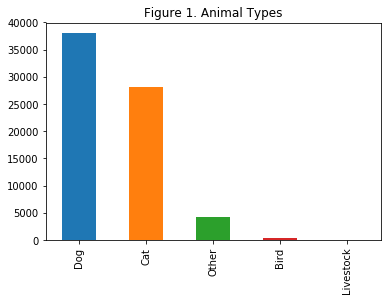

In [12]:
df['animal_type'].value_counts().plot(kind='bar', title='Figure 1. Animal Types')
df['animal_type'].value_counts()

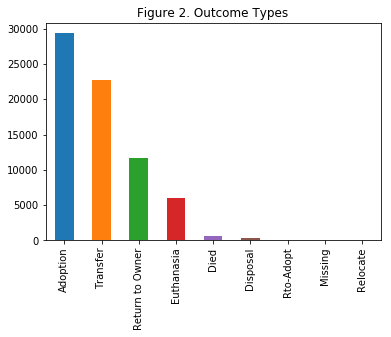

In [13]:
df['outcome_type'].value_counts().plot(kind='bar', title='Figure 2. Outcome Types')

In [14]:
df[df['animal_type'] == "Dog"]["breed"].value_counts().head()

Pit Bull Mix                 4919
Chihuahua Shorthair Mix      4326
Labrador Retriever Mix       3994
German Shepherd Mix          1617
Australian Cattle Dog Mix     922
Name: breed, dtype: int64

In [15]:
df[df['animal_type'] == 'Cat']['breed'].value_counts().head()

Domestic Shorthair Mix      22390
Domestic Medium Hair Mix     2227
Domestic Longhair Mix        1172
Siamese Mix                   948
Domestic Shorthair            370
Name: breed, dtype: int64

In [16]:
df[df['animal_type'] == "Other"]['breed'].value_counts().head()

Bat Mix          1284
Bat               798
Raccoon Mix       465
Rabbit Sh Mix     288
Raccoon           230
Name: breed, dtype: int64

In [17]:
len(df[df['outcome_type'] == 'Died'])

673

In [18]:
df[df['outcome_type'] == 'Died']['age_binned'].value_counts()

(-0.001, 75.0]      343
(75.0, 248.0]        89
(248.0, 554.0]       88
(1139.0, 9137.0]     78
(554.0, 1139.0]      75
Name: age_binned, dtype: int64

In [19]:
df[df['outcome_type'] == 'Died']['animal_type'].value_counts()

Cat      400
Dog      135
Other    134
Bird       4
Name: animal_type, dtype: int64

## Decision Tree - all animals

In [20]:
Y, X = dmatrices('adopted ~ 0 + animal_type + has_name +  days_alive + age_binned + sex_upon_outcome + month', df, return_type='dataframe')
y = Y['adopted'].values
X.head()

,animal_type[Bird],animal_type[Cat],animal_type[Dog],animal_type[Livestock],animal_type[Other],"age_binned[T.Interval(75.0, 248.0, closed='right')]","age_binned[T.Interval(248.0, 554.0, closed='right')]","age_binned[T.Interval(554.0, 1139.0, closed='right')]","age_binned[T.Interval(1139.0, 9137.0, closed='right')]",sex_upon_outcome[T.Intact Male],sex_upon_outcome[T.Neutered Male],sex_upon_outcome[T.Spayed Female],sex_upon_outcome[T.Unknown],has_name,days_alive,month
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15.0,7.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,366.0,11.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,429.0,6.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3300.0,6.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,181.0,7.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [22]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 10)

In [23]:
result = model.fit(X_train, y_train)
prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

0.799669308168


In [24]:
prediction = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction)

0.797365325806


## Decision Tree - Only Dogs and Cats

In [25]:
df_copy = df.copy()
mask = df_copy['animal_type'].isin(["Dog", "Cat"])
df_copy = df_copy[mask]
df_copy

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,days_alive,age_binned,month,adopted
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,0,15,"(-0.001, 75.0]",7,0
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,1,366,"(248.0, 554.0]",11,0
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,429,"(248.0, 554.0]",6,1
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,1,3300,"(1139.0, 9137.0]",6,0
5,4 months,Dog,Leonberger Mix,Brown/White,2013-06-03,2013-10-07 13:06:00,*Edgar,Partner,Transfer,Intact Male,1,126,"(75.0, 248.0]",10,0
7,3 years,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23,2014-12-08 15:55:00,*Ella,Partner,Transfer,Spayed Female,1,1111,"(554.0, 1139.0]",12,0
8,1 month,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16,2014-08-14 18:45:00,Lucy,NaN,Adoption,Intact Female,1,59,"(-0.001, 75.0]",8,1
9,3 months,Cat,Domestic Shorthair Mix,White/Black,2014-03-26,2014-06-29 17:45:00,*Frida,Offsite,Adoption,Spayed Female,1,95,"(75.0, 248.0]",6,1
10,1 year,Cat,Domestic Medium Hair Mix,Black/White,2013-03-27,2014-03-28 14:55:00,Stella Luna,NaN,Return to Owner,Spayed Female,1,366,"(248.0, 554.0]",3,0
11,2 years,Dog,Papillon/Border Collie,Black/White,2012-02-28,2014-03-28 14:39:00,Fancy,Partner,Transfer,Neutered Male,1,759,"(554.0, 1139.0]",3,0


In [26]:
Y, X = dmatrices('adopted ~ 0 + animal_type + days_alive + has_name + sex_upon_outcome + age_binned + month', df_copy, return_type='dataframe')
y = Y['adopted'].values
X.head()

,animal_type[Cat],animal_type[Dog],sex_upon_outcome[T.Intact Male],sex_upon_outcome[T.Neutered Male],sex_upon_outcome[T.Spayed Female],sex_upon_outcome[T.Unknown],"age_binned[T.Interval(75.0, 248.0, closed='right')]","age_binned[T.Interval(248.0, 554.0, closed='right')]","age_binned[T.Interval(554.0, 1139.0, closed='right')]","age_binned[T.Interval(1139.0, 9137.0, closed='right')]",days_alive,has_name,month
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,7.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,366.0,1.0,11.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,429.0,1.0,6.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3300.0,1.0,6.0
5,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,126.0,1.0,10.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 10)

In [28]:
result = model.fit(X_train, y_train)
prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

0.797689107331


In [29]:
prediction = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction)

0.784769377798


# Naive Bayes

Let's do some preprocessing first.

In [30]:
categorical_columns = ['age_binned', 'animal_type', 'sex_upon_outcome', 'month']
df_dummies = pd.get_dummies(df[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = df_dummies.columns.values
dummy_column_names[:10]

array(['age_binned_(-0.001, 75.0]', 'age_binned_(75.0, 248.0]',
       'age_binned_(248.0, 554.0]', 'age_binned_(554.0, 1139.0]',
       'age_binned_(1139.0, 9137.0]', 'animal_type_Bird',
       'animal_type_Cat', 'animal_type_Dog', 'animal_type_Livestock',
       'animal_type_Other'], dtype=object)

In [31]:
df2 = pd.concat([df, df_dummies], axis=1)
df2.head()

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,...,0,0,0,0,1,0,0,0,0,0
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,...,0,0,0,0,0,0,0,0,1,0
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,...,0,0,0,1,0,0,0,0,0,0
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,...,0,0,0,1,0,0,0,0,0,0
4,5 months,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,...,0,0,0,0,1,0,0,0,0,0


In [32]:
formula = 'adopted ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))
print formula

adopted ~ 0 + Q("age_binned_(-0.001, 75.0]") + Q("age_binned_(75.0, 248.0]") + Q("age_binned_(248.0, 554.0]") + Q("age_binned_(554.0, 1139.0]") + Q("age_binned_(1139.0, 9137.0]") + Q("animal_type_Bird") + Q("animal_type_Cat") + Q("animal_type_Dog") + Q("animal_type_Livestock") + Q("animal_type_Other") + Q("sex_upon_outcome_Intact Female") + Q("sex_upon_outcome_Intact Male") + Q("sex_upon_outcome_Neutered Male") + Q("sex_upon_outcome_Spayed Female") + Q("sex_upon_outcome_Unknown") + Q("month_1") + Q("month_2") + Q("month_3") + Q("month_4") + Q("month_5") + Q("month_6") + Q("month_7") + Q("month_8") + Q("month_9") + Q("month_10") + Q("month_11") + Q("month_12")


In [33]:
Y, X = dmatrices(formula, df2, return_type='dataframe')
y = Y['adopted'].values

In [34]:
from sklearn import naive_bayes
model = naive_bayes.MultinomialNB()

In [35]:
model.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
print 'Prediction'
print model.predict(X[:10])
print 'Actual'
print y[:10]

Prediction
[ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
Actual
[ 0.  0.  1.  0.  0.  0.  0.  0.  1.  1.]


In [37]:
from sklearn import metrics

prediction_train = model.predict(X)
print metrics.accuracy_score(y, prediction_train)

0.738983768525


In [38]:
print exp(model.class_log_prior_[0])

0.585942131263


In [39]:
feature_importances = abs(model.feature_log_prob_[1] - model.feature_log_prob_[0])
feature_importances

array([ 0.20457311,  0.88069525,  0.02823868,  0.24250324,  0.44378668,
        0.30609481,  0.03716518,  0.14136403,  0.63369349,  2.63187207,
        2.10054724,  2.29051543,  0.67275567,  0.87724014,  4.16835624,
        0.1840047 ,  0.10283933,  0.32061614,  0.43205956,  0.28440206,
        0.01767543,  0.28480756,  0.12794692,  0.05092612,  0.10379172,
        0.05776972,  0.27617035])

In [40]:
feature_importance_series = Series(feature_importances, index=X.columns.values)
feature_importance_series.sort_values(ascending=False)[:50]

Q("sex_upon_outcome_Unknown")          4.168356
Q("animal_type_Other")                 2.631872
Q("sex_upon_outcome_Intact Male")      2.290515
Q("sex_upon_outcome_Intact Female")    2.100547
Q("age_binned_(75.0, 248.0]")          0.880695
Q("sex_upon_outcome_Spayed Female")    0.877240
Q("sex_upon_outcome_Neutered Male")    0.672756
Q("animal_type_Livestock")             0.633693
Q("age_binned_(1139.0, 9137.0]")       0.443787
Q("month_4")                           0.432060
Q("month_3")                           0.320616
Q("animal_type_Bird")                  0.306095
Q("month_7")                           0.284808
Q("month_5")                           0.284402
Q("month_12")                          0.276170
Q("age_binned_(554.0, 1139.0]")        0.242503
Q("age_binned_(-0.001, 75.0]")         0.204573
Q("month_1")                           0.184005
Q("animal_type_Dog")                   0.141364
Q("month_8")                           0.127947
Q("month_10")                          0

In [41]:
top_10_feature_indices = feature_importance_series.sort_values(ascending=False)[:20].index.values

In [42]:
inter_class_differences = model.feature_log_prob_[1] - model.feature_log_prob_[0]
new_feature_importance_series = Series(inter_class_differences, index=X.columns.values)

new_feature_importance_series[top_10_feature_indices]

Q("sex_upon_outcome_Unknown")         -4.168356
Q("animal_type_Other")                -2.631872
Q("sex_upon_outcome_Intact Male")     -2.290515
Q("sex_upon_outcome_Intact Female")   -2.100547
Q("age_binned_(75.0, 248.0]")          0.880695
Q("sex_upon_outcome_Spayed Female")    0.877240
Q("sex_upon_outcome_Neutered Male")    0.672756
Q("animal_type_Livestock")            -0.633693
Q("age_binned_(1139.0, 9137.0]")      -0.443787
Q("month_4")                          -0.432060
Q("month_3")                          -0.320616
Q("animal_type_Bird")                 -0.306095
Q("month_7")                           0.284808
Q("month_5")                          -0.284402
Q("month_12")                          0.276170
Q("age_binned_(554.0, 1139.0]")       -0.242503
Q("age_binned_(-0.001, 75.0]")        -0.204573
Q("month_1")                           0.184005
Q("animal_type_Dog")                   0.141364
Q("month_8")                           0.127947
dtype: float64

# Naive Bayes - Dogs Only

In [43]:
df_copy = df.copy()
mask = df_copy['animal_type'].isin(["Dog", "Cat"])
df_copy = df_copy[mask]
df_copy
df_copy['target'] = 0.0
mask = (df['outcome_type'] == 'Adoption')
df_copy['target'][mask] = 1.0
df_copy['target'].value_counts()

0.0    37256
1.0    29016
Name: target, dtype: int64

In [44]:
df['breed_count'] = df.groupby(['breed'])['animal_type'].transform('count')
df_breed = df[df['animal_type'] == "Dog"]
df_breed = df_breed[df_breed['breed_count'] >= 500]
df_breed

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,days_alive,age_binned,month,adopted,breed_count
7,3 years,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23,2014-12-08 15:55:00,*Ella,Partner,Transfer,Spayed Female,1,1111,"(554.0, 1139.0]",12,0,4326
14,8 years,Dog,Labrador Retriever Mix,Black,2006-10-18,2014-10-26 18:20:00,Shy,NaN,Return to Owner,Neutered Male,1,2930,"(1139.0, 9137.0]",10,0,3994
16,1 year,Dog,Pit Bull Mix,Brown Brindle/White,2013-03-11,2014-04-16 12:51:00,*Newt,Partner,Transfer,Neutered Male,1,401,"(248.0, 554.0]",4,0,4919
27,2 months,Dog,Labrador Retriever Mix,Yellow,2013-09-01,2013-11-19 18:30:00,Promise,NaN,Adoption,Spayed Female,1,79,"(75.0, 248.0]",11,1,3994
28,4 months,Dog,Chihuahua Shorthair Mix,Blue/Tan,2014-06-17,2014-11-04 18:03:00,Minnie,Partner,Transfer,Intact Female,1,140,"(75.0, 248.0]",11,0,4326
32,3 months,Dog,Labrador Retriever Mix,Tan/White,2013-09-30,2014-01-03 17:47:00,NaN,NaN,Adoption,Spayed Female,0,95,"(75.0, 248.0]",1,1,3994
34,12 years,Dog,Labrador Retriever Mix,Black/White,2002-05-08,2014-07-09 11:54:00,Shades,Foster,Adoption,Neutered Male,1,4445,"(1139.0, 9137.0]",7,1,3994
36,2 years,Dog,Chihuahua Shorthair Mix,Buff,2012-04-22,2014-04-26 13:00:00,*Penny,NaN,Adoption,Spayed Female,1,734,"(554.0, 1139.0]",4,1,4326
45,3 years,Dog,Border Collie Mix,Black/White,2010-08-09,2013-10-13 15:10:00,Oreo,NaN,Adoption,Spayed Female,1,1161,"(1139.0, 9137.0]",10,1,553
48,1 year,Dog,Boxer Mix,Brown,2013-11-29,2014-12-01 18:30:00,Lex,NaN,Return to Owner,Neutered Male,1,367,"(248.0, 554.0]",12,0,556


In [45]:
df_breed['color_count'] = df_breed.groupby(['color'])['animal_type'].transform('count')
df_breed_color = df_breed[df_breed['color_count'] >= 1000]
df_breed_color

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,days_alive,age_binned,month,adopted,breed_count,color_count
14,8 years,Dog,Labrador Retriever Mix,Black,2006-10-18,2014-10-26 18:20:00,Shy,NaN,Return to Owner,Neutered Male,1,2930,"(1139.0, 9137.0]",10,0,3994,1334
32,3 months,Dog,Labrador Retriever Mix,Tan/White,2013-09-30,2014-01-03 17:47:00,NaN,NaN,Adoption,Spayed Female,0,95,"(75.0, 248.0]",1,1,3994,1077
34,12 years,Dog,Labrador Retriever Mix,Black/White,2002-05-08,2014-07-09 11:54:00,Shades,Foster,Adoption,Neutered Male,1,4445,"(1139.0, 9137.0]",7,1,3994,2341
45,3 years,Dog,Border Collie Mix,Black/White,2010-08-09,2013-10-13 15:10:00,Oreo,NaN,Adoption,Spayed Female,1,1161,"(1139.0, 9137.0]",10,1,553,2341
53,6 years,Dog,Pit Bull Mix,Black/White,2007-05-31,2014-05-04 15:20:00,Ittybitty,Aggressive,Euthanasia,Spayed Female,1,2530,"(1139.0, 9137.0]",5,0,4919,2341
58,1 year,Dog,Chihuahua Shorthair Mix,Brown/White,2013-04-25,2014-05-01 17:05:00,Tinker Bell,NaN,Adoption,Spayed Female,1,371,"(248.0, 554.0]",5,1,4326,1108
97,1 year,Dog,German Shepherd Mix,Tan/White,2013-09-26,2014-12-04 17:22:00,*Flicker,Partner,Transfer,Spayed Female,1,434,"(248.0, 554.0]",12,0,1617,1077
118,8 months,Dog,Border Collie Mix,Black/White,2013-11-19,2014-07-23 18:33:00,Ruby,NaN,Adoption,Spayed Female,1,246,"(75.0, 248.0]",7,1,553,2341
131,1 year,Dog,Dachshund Mix,Brown/White,2012-08-17,2014-02-22 18:22:00,NaN,Partner,Transfer,Neutered Male,0,554,"(248.0, 554.0]",2,0,738,1108
138,1 year,Dog,Labrador Retriever Mix,Black,2013-03-24,2014-04-28 11:32:00,*Drake,NaN,Adoption,Neutered Male,1,400,"(248.0, 554.0]",4,1,3994,1334


In [46]:
df_breed_color['adopted'] = 0.0
mask = (df_breed_color['outcome_type'] == 'Adoption')
df_breed_color['adopted'][mask] = 1.0
df_breed_color['adopted'].value_counts()

0.0    3162
1.0    2698
Name: adopted, dtype: int64

In [47]:
categorical_columns = ['age_binned', 'sex_upon_outcome', 'month', 'breed']
df_dummies = pd.get_dummies(df[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = df_dummies.columns.values
dummy_column_names[:10]

array(['age_binned_(-0.001, 75.0]', 'age_binned_(75.0, 248.0]',
       'age_binned_(248.0, 554.0]', 'age_binned_(554.0, 1139.0]',
       'age_binned_(1139.0, 9137.0]', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown'], dtype=object)

In [48]:
df4 = pd.concat([df_breed_color, df_dummies], axis=1)

In [ ]:
formula = 'adopted ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))
print formula

adopted ~ 0 + Q("age_binned_(-0.001, 75.0]") + Q("age_binned_(75.0, 248.0]") + Q("age_binned_(248.0, 554.0]") + Q("age_binned_(554.0, 1139.0]") + Q("age_binned_(1139.0, 9137.0]") + Q("sex_upon_outcome_Intact Female") + Q("sex_upon_outcome_Intact Male") + Q("sex_upon_outcome_Neutered Male") + Q("sex_upon_outcome_Spayed Female") + Q("sex_upon_outcome_Unknown") + Q("month_1") + Q("month_2") + Q("month_3") + Q("month_4") + Q("month_5") + Q("month_6") + Q("month_7") + Q("month_8") + Q("month_9") + Q("month_10") + Q("month_11") + Q("month_12") + Q("breed_Abyssinian Mix") + Q("breed_Affenpinscher Mix") + Q("breed_Afghan Hound Mix") + Q("breed_Afghan Hound/Labrador Retriever") + Q("breed_African Mix") + Q("breed_Airedale Terrier") + Q("breed_Airedale Terrier Mix") + Q("breed_Airedale Terrier/Irish Terrier") + Q("breed_Airedale Terrier/Labrador Retriever") + Q("breed_Airedale Terrier/Miniature Schnauzer") + Q("breed_Akbash Mix") + Q("breed_Akita") + Q("breed_Akita Mix") + Q("breed_Akita/Austral

In [ ]:
Y, X = dmatrices(formula, df4, return_type='dataframe')
y = Y['adopted'].values
y[:10]

In [ ]:
model.fit(X, y)

print 'Prediction'
print model.predict(X[:10])
print 'Actual'
print y[:10]

In [ ]:
prediction_train = model.predict(X)
print metrics.accuracy_score(y, prediction_train)

In [ ]:
print exp(model.class_log_prior_[0])

In [ ]:
feature_importances = abs(model.feature_log_prob_[1] - model.feature_log_prob_[0])
feature_importances

In [ ]:
feature_importance_series = Series(feature_importances, index=X.columns.values)
feature_importance_series[:20]

In [ ]:
feature_importance_series.sort_values(ascending=False)[:20]

In [ ]:
top_10_feature_indices = feature_importance_series.sort_values(ascending=False)[:20].index.values

In [ ]:
inter_class_differences = model.feature_log_prob_[1] - model.feature_log_prob_[0]
new_feature_importance_series = Series(inter_class_differences, index=X.columns.values)

new_feature_importance_series[top_10_feature_indices]